# Analyzing an active composite network of actin and microtubules

<div class="alert alert-block alert-info">
<b>Tip:</b> Use blue boxes (alert-info) for tips and notes. 
If it’s a note, you don’t have to include the word “Note”.
</div>

## Importing the necessary modules

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import numpy as np #numerical python used for working with arrays, mathematical operations
import xarray as xr #package for labeling and adding metadata to multi-dimensional arrays

import sys
sys.path.append("../PyDDM") #must point to the PyDDM folder
import ddm_analysis_and_fitting as ddm

## Initiazing DDM_Analysis class and computing the DDM matrix


In [4]:
ddm_calc = ddm.DDM_Analysis("active_network_data.yml")

Provided metadata: {'pixel_size': 0.83, 'frame_rate': 2.78, 'channel': 0}
According to nd2 file:
	256 x 256 px
	Pixel size of: 0.83 microns
	Number of frames: 1001
Image shape: 1001-by-256-by-256
Number of frames to use for analysis: 1001
Maximum lag time (in frames): 700
Number of lag times to compute DDM matrix: 50


2022-01-31 16:45:38,217 - DDM Calculations - Running dt = 1...
2022-01-31 16:46:05,364 - DDM Calculations - Running dt = 5...
2022-01-31 16:46:22,155 - DDM Calculations - Running dt = 9...
2022-01-31 16:46:38,776 - DDM Calculations - Running dt = 14...
2022-01-31 16:46:54,883 - DDM Calculations - Running dt = 21...
2022-01-31 16:47:11,085 - DDM Calculations - Running dt = 32...
2022-01-31 16:47:27,493 - DDM Calculations - Running dt = 49...
2022-01-31 16:47:43,281 - DDM Calculations - Running dt = 76...
2022-01-31 16:47:58,359 - DDM Calculations - Running dt = 116...
2022-01-31 16:48:12,673 - DDM Calculations - Running dt = 177...
2022-01-31 16:48:25,728 - DDM Calculations - Running dt = 270...
2022-01-31 16:48:36,802 - DDM Calculations - Running dt = 412...
2022-01-31 16:48:45,226 - DDM Calculations - Running dt = 629...


DDM matrix took 189.73387837409973 seconds to compute.
 Background estimate ± std is 62861.89 ± 1157.71


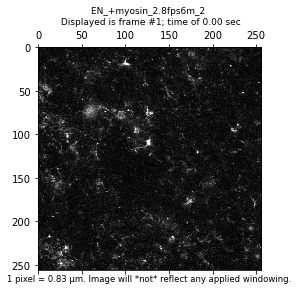

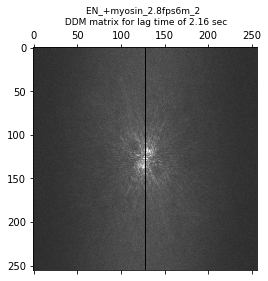

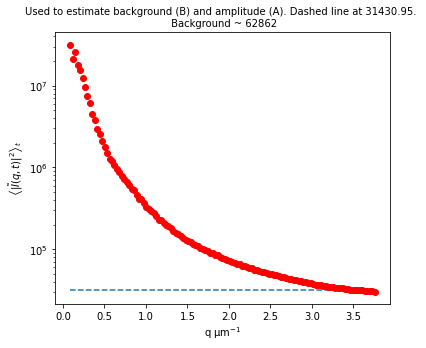

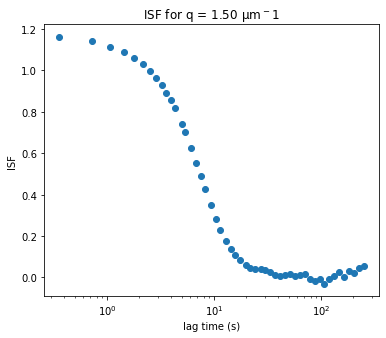

In [5]:
ddm_calc.calculate_DDM_matrix(overlap_method=3)

## Initiazing DDM_Fit class and fitting our data to a model
Next, we initialize the `DDM_Fit` class which will help us fit the calculated DDM matrix to a model of our choosing. 


In [6]:
ddm_fit = ddm.DDM_Fit(ddm_calc.data_yaml)

,Initial guess,Minimum,Maximum
Amplitude,1000.0,1.000,100000000.0
Tau,100.0,0.001,2000.0
Background,50000.0,0.000,100000.0
StretchingExp,1.7,0.900,3.0


Loading file Y:/Gloria/Confocal Videos/20200120_EN/EN_+myosin_2.8fps6m_2_ddmmatrix.nc ...


In [7]:
fit01 = ddm_fit.fit(name_fit = 'fit01')

In function 'get_tau_vs_q_fit', using new tau...
Fit is saved in fittings dictionary with key 'fit01'.


,q,Amplitude,Tau,Background,StretchingExp
0,0.000000,1.000000,2000.000000,0.000003,3.000000
1,0.029571,64440415.885648,99.882086,100000.000000,2.045260
2,0.059141,78170870.106938,86.504429,100000.000000,2.014226
3,0.088712,59806983.165115,110.448951,0.000000,1.700949
4,0.118283,36485154.507687,71.725721,100000.000000,1.937473
5,0.147854,35377945.973877,65.510227,100000.000000,1.995169
6,0.177424,28466993.102044,65.466356,100000.000000,1.895588
7,0.206995,28124940.057893,59.102971,100000.000000,1.929159
8,0.236566,22139569.294439,56.026185,39923.420834,1.777847
9,0.266136,17716016.238777,43.294538,100000.000000,1.964221


We can now take a look at the best fit parameters determined by the fitting code. We can generate a set of plots and have the output saved as PDF with the function `fit_report`. 

In function 'get_tau_vs_q_fit', using new tau...
In hf.plot_one_tau_vs_q function, using new tau... 


<xarray.Dataset>
Dimensions:          (parameter: 4, q: 128, lagtime: 50)
Coordinates:
  * parameter        (parameter) <U13 'Amplitude' 'Tau' ... 'StretchingExp'
  * q                (q) float64 0.0 0.02957 0.05914 ... 3.696 3.726 3.755
  * lagtime          (lagtime) float64 0.3597 0.7194 1.079 ... 203.6 226.3 251.8
Data variables:
    parameters       (parameter, q) float64 1.0 6.444e+07 ... 1.21 1.198
    theory           (lagtime, q) float64 3.287e-06 1.006e+05 ... 6.037e+04
    isf_data         (lagtime, q) float64 ...
    ddm_matrix_data  (lagtime, q) float64 ...
    A                (q) float64 -6.286e+04 1.473e+08 ... -1.298e+03 -2.192e+03
    B                float64 6.286e+04
Attributes: (12/18)
    model:                          DDM Matrix - Single Exponential
    data_to_use:                    DDM Matrix
    initial_params_dict:            ["{'n': 0, 'value': 1000.0, 'limits': [1....
    effective_diffusion_coeff:      0.08640949421975963
    tau_vs_q_slope:                 [-1.12092402]
    msd_alpha:                      [1.78424225]
    ...                             ...
    DataDirectory:                  Y:/Gloria/Confocal Videos/20200120_EN/
    FileName:                       EN_+myosin_2.8fps6m_2.nd2
    pixel_size:                     0.83
    frame_rate:                     2.78
    BackgroundMethod:               0
    OverlapMethod:                  3

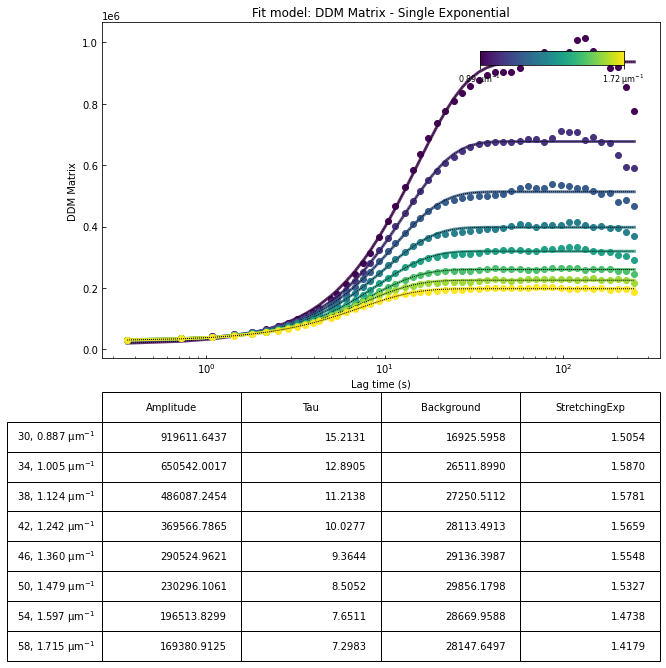

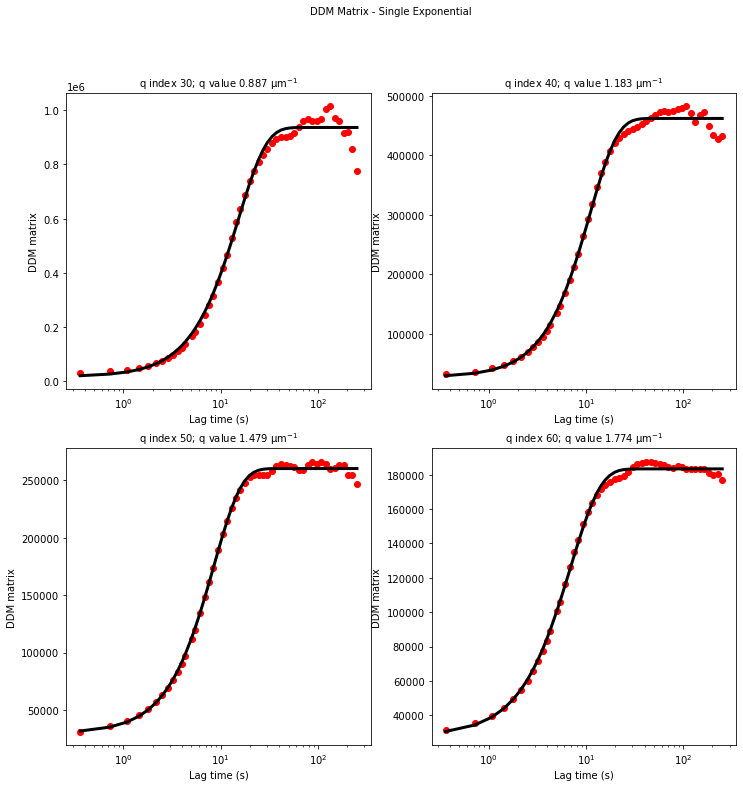

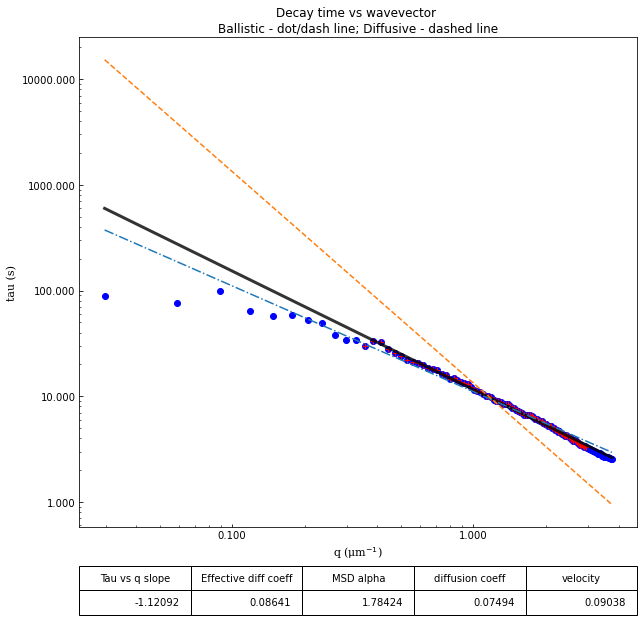

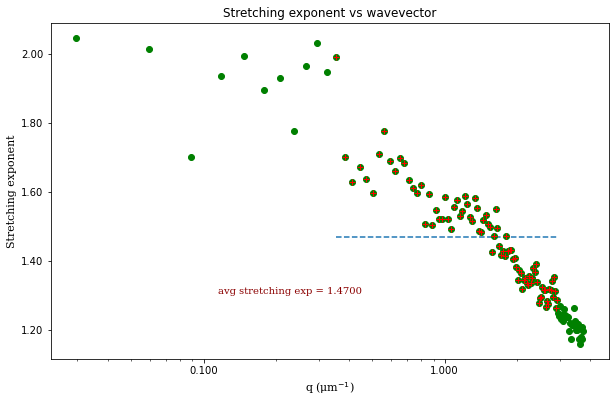

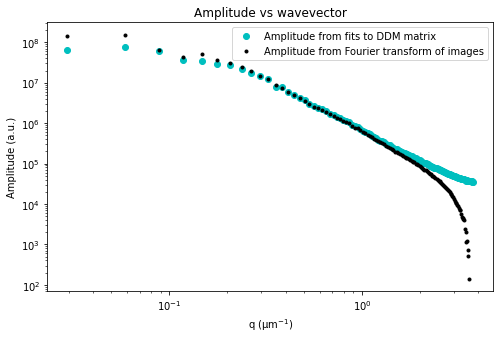

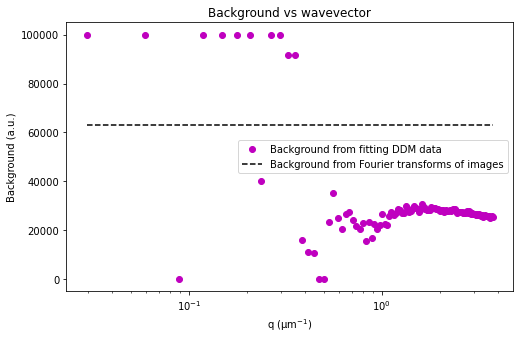

In [8]:
ddm.fit_report(fit01, q_indices=[30,40,50,60], use_new_tau=True, show=True, forced_qs = [12,100])

### Thinking about what range of decay times are accessible

In [9]:
smallest_lag_time = 1./fit01.frame_rate
print("The time interval between adjacent frames is %.3f s." % smallest_lag_time)
largest_lag_time = fit01.lagtime[-1]
print("The longest lag time is %.3f s." % largest_lag_time)

The time interval between adjacent frames is 0.360 s.
The longest lag time is 251.799 s.


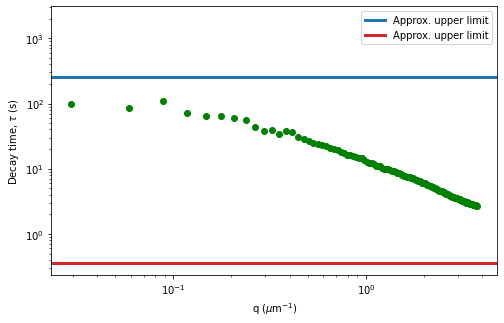

In [11]:
fig,ax = plt.subplots(figsize=(8,8/1.618))
plt.loglog(fit01.q, fit01.parameters.loc['Tau'], 'go')
plt.xlabel("q ($\mu$m$^{-1}$)");
plt.ylabel("Decay time, $\\tau$ (s)");
plt.axhline(y=largest_lag_time, color='tab:blue', lw=3, label="Approx. upper limit")
plt.axhline(y=smallest_lag_time, color='tab:red', lw=3, label="Approx. upper limit")
plt.legend()

### Trying to fit the ISF instead of the DDM matrix
Above, we performed a fit of DDM matrix to a model where the intermediate scattering function (ISF or $f(q,\Delta t)$) is an exponential. That is, we fit our data to:
$$ D(q,\Delta t) = A(q) \left[ 1 - \exp \left(-\Delta t / \tau(q) \right) ^{s(q)} \right] + B(q)$$
where $A$ is the amplitude, $B$ is the background, $\tau$ is the decay time, and $s$ is the stretching exponent. 

An alternative is to use other information to determine $A(q)$ and $B$ and then fit only the ISF. 

But to do this, we must be confident in estimating $B$ and then $A(q)$.

Recall that we estimate the background by finding $\left< | \tilde{I}(q, t) |^2 \right>_t$ which is saved as `avg_image_ft` in the `ddm_dataset`. We assume that $\left< | \tilde{I}(q, t) |^2 \right>_t = 0.5 \times \left[ A(q) + B \right]$ and that as $q$ gets large, the amplitude $A$ goes to zero. If that's the case, then for large $q$ we should see $\left< | \tilde{I}(q, t) |^2 \right>_t$ plateau to a constant which will equal half the background $B$.

Our estimate of the background was 62861.9.


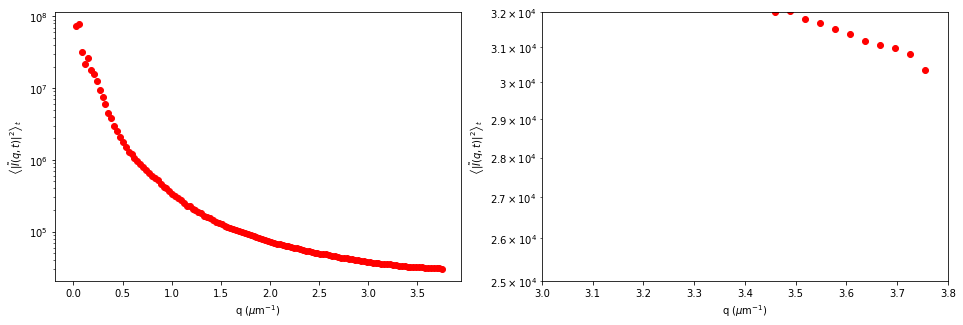

In [12]:
fig,axs = plt.subplots(1,2,figsize=(8*2,8/1.618))
axs[0].semilogy(ddm_fit.ddm_dataset.q, ddm_fit.ddm_dataset.avg_image_ft, 'ro')
axs[0].set_xlabel(r"q ($\mu$m$^{-1}$)")
axs[0].set_ylabel(r"$\left< | \tilde{I}(q, t) |^2 \right>_t$")
axs[1].semilogy(ddm_fit.ddm_dataset.q, ddm_fit.ddm_dataset.avg_image_ft, 'ro')
axs[1].set_xlim(3,3.8)
axs[1].set_ylim(2.5e4,3.2e4)
axs[1].set_xlabel(r"q ($\mu$m$^{-1}$)")
axs[1].set_ylabel(r"$\left< | \tilde{I}(q, t) |^2 \right>_t$")

print("Our estimate of the background was %.1f." % ddm_fit.ddm_dataset.B)

In [13]:
ddm_fit.ddm_dataset = ddm.recalculate_ISF_with_new_background(ddm_fit.ddm_dataset, background_method=1)
print("The background is now estimated to be %.2f." % ddm_fit.ddm_dataset.B)

The background is now estimated to be 31857.10.


In [14]:
ddm_fit.reload_fit_model_by_name("ISF - Single Exponential")

,Initial guess,Minimum,Maximum
Tau,100.0,0.001,2000.0
StretchingExp,1.7,0.900,3.0


In [15]:
fit02 = ddm_fit.fit(name_fit = 'fit02')

In function 'get_tau_vs_q_fit', using new tau...
Fit is saved in fittings dictionary with key 'fit02'.


,q,Tau,StretchingExp
0,0.000000,0.092618,1.990802
1,0.029571,298.361023,1.197480
2,0.059141,236.255136,1.146636
3,0.088712,119.644918,1.618241
4,0.118283,87.766337,1.618110
5,0.147854,124.910723,1.174909
6,0.177424,91.460138,1.399752
7,0.206995,67.171903,1.709318
8,0.236566,65.992030,1.557132
9,0.266136,47.233413,1.780025


<xarray.Dataset>
Dimensions:          (parameter: 2, q: 128, lagtime: 50)
Coordinates:
  * parameter        (parameter) <U13 'Tau' 'StretchingExp'
  * q                (q) float64 0.0 0.02957 0.05914 ... 3.696 3.726 3.755
  * lagtime          (lagtime) float64 0.3597 0.7194 1.079 ... 203.6 226.3 251.8
Data variables:
    parameters       (parameter, q) float64 0.09262 298.4 236.3 ... 1.583 1.613
    theory           (lagtime, q) float64 3.391e-07 0.9997 0.9994 ... 0.0 0.0
    isf_data         (lagtime, q) float64 0.0 1.0 1.0 ... 0.02563 0.02646
    ddm_matrix_data  (lagtime, q) float64 ...
    A                (q) float64 -3.186e+04 1.473e+08 ... 2.971e+04 2.881e+04
    B                float64 3.186e+04
Attributes: (12/18)
    model:                          ISF - Single Exponential
    data_to_use:                    ISF
    initial_params_dict:            ["{'n': 0, 'value': 100.0, 'limits': [0.0...
    effective_diffusion_coeff:      0.07838239296049708
    tau_vs_q_slope:                 [-1.0737212]
    msd_alpha:                      [1.86268092]
    ...                             ...
    DataDirectory:                  Y:/Gloria/Confocal Videos/20200120_EN/
    FileName:                       EN_+myosin_2.8fps6m_2.nd2
    pixel_size:                     0.83
    frame_rate:                     2.78
    BackgroundMethod:               1
    OverlapMethod:                  3

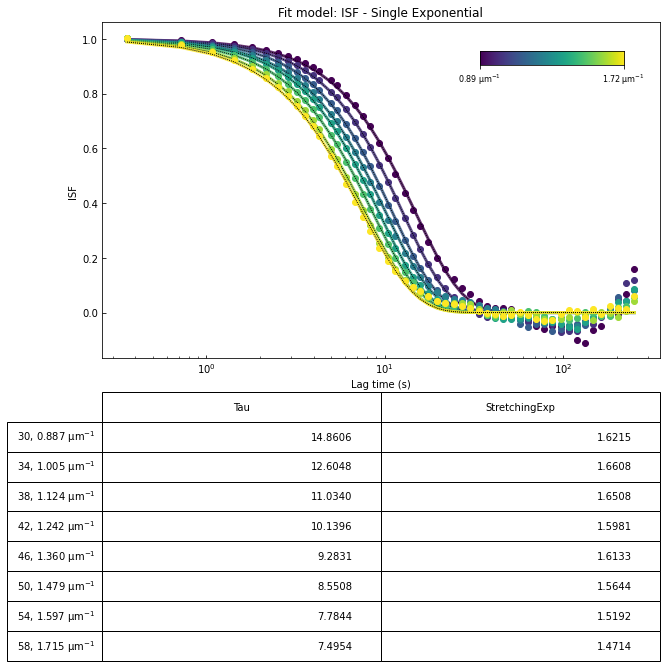

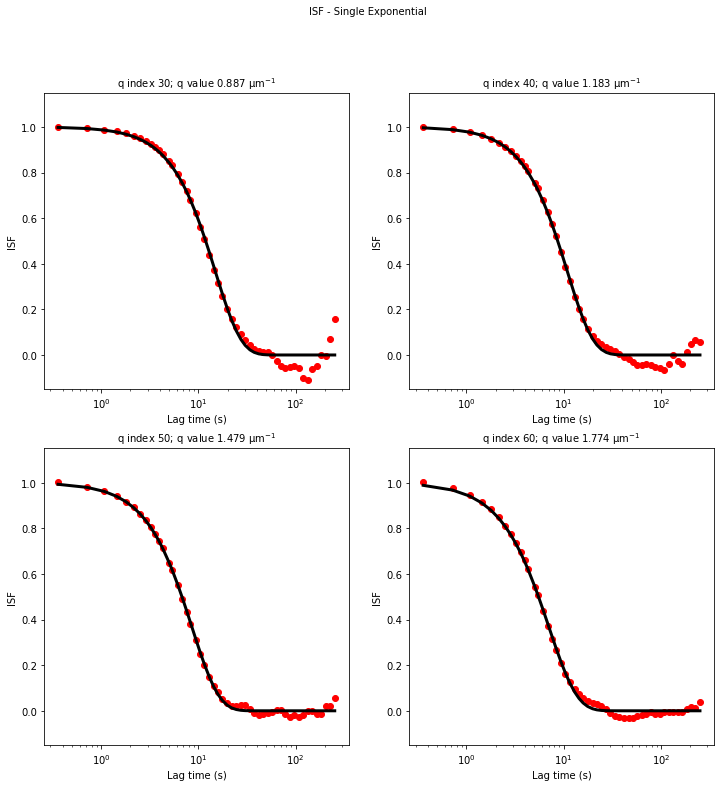

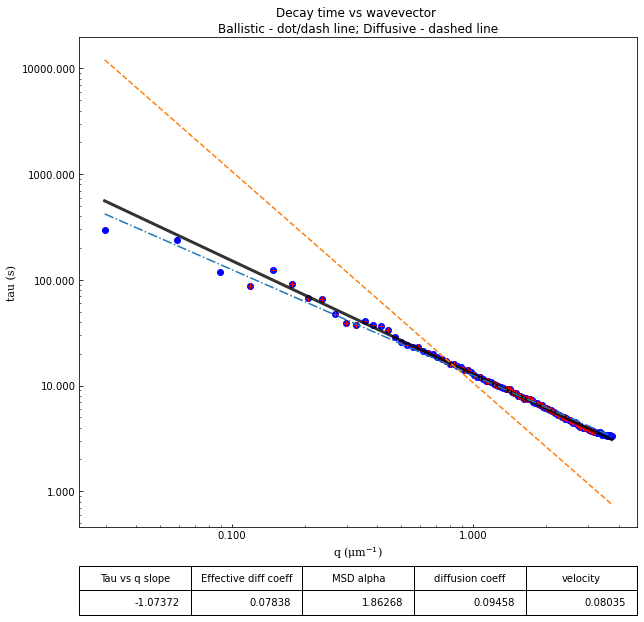

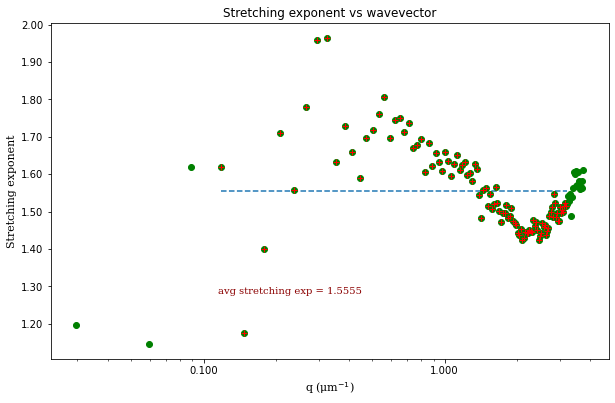

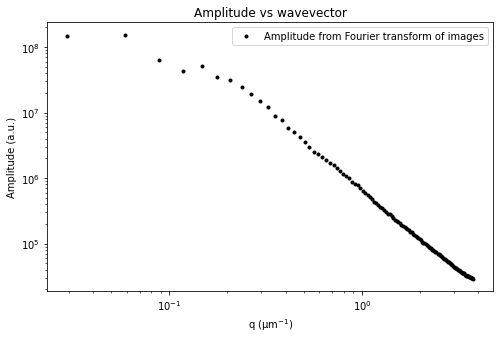

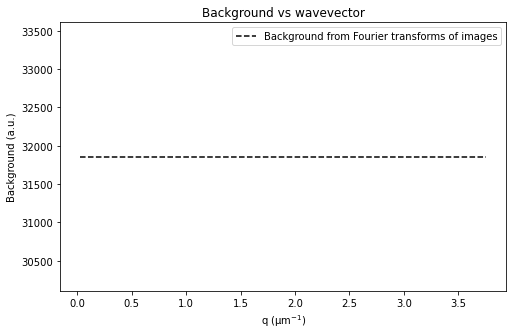

In [16]:
ddm.fit_report(fit02, q_indices=[30,40,50,60], use_new_tau=False, show=True)

In [17]:
fit02.to_netcdf("Fit_20200120_EN_+myosin_2.8fps6m_2_ISFFits.nc")

In [18]:
fit01.to_netcdf("Fit_20200120_EN_+myosin_2.8fps6m_2_DDMMatrixFits.nc")

## Interactive with matplotlib

<IPython.core.display.Javascript object>


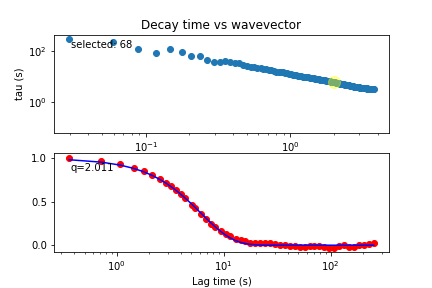

Click on a point in the tau vs q plot to see a fit.
Or press 'N' or 'P' to display next or previous fit.


Text(0, 0.5, 'tau (s)')

In [19]:
%matplotlib notebook
fig, (ax, ax2) = plt.subplots(2, 1)
browser = ddm.Browse_DDM_Fits(fig, ax, ax2, fit02)

fig.canvas.mpl_connect('pick_event', browser.on_pick)
fig.canvas.mpl_connect('key_press_event', browser.on_press)

ax.set_title('Decay time vs wavevector')
ax.set_xlabel("q")
ax.set_ylabel("tau (s)")

## Saving the results

In [ ]:
ddm.save_fit_results_to_excel(fit01)

In [ ]:
fit01.to_netcdf("example_netcdf_file.nc")

In [ ]:
loaded_netcdf_file = xr.open_dataset("example_netcdf_file.nc")